In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK: 0,
    BOWHEAD: 1,
    NOISE: 2
}

# label to type
label_to_type = {
    0: HUMPBACK,
    1: BOWHEAD,
    2: NOISE
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio),
               get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_MOOS, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback :  36
bowhead :  34
noise :  62


In [4]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [11]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

In [12]:
# save pickle for else where
import pickle
print("Writing to pickle file: " + 'train-test-val' + ".pkl")
output = open('train-test-val' + ".pkl", "wb")
pickle.dump({'train': train, 'val':val, 'test':test}, output)
output.close()

Writing to pickle file: train-test-val.pkl


In [47]:
def get_mfcc_feature(sample, fs, nfft):

    return librosa.feature.mfcc(y=sample,sr=fs,n_mfcc=13,kwargs={'nfft': nfft})

In [6]:
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=256)
    return feat

# Train

In [ ]:
# train hmms
from hmmlearn.hmm import GaussianHMM

hmms = {
    HUMPBACK: GaussianHMM(5),
    BOWHEAD: GaussianHMM(5),
    NOISE: GaussianHMM(4)
}

train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample))

for key in hmms:
    cur_hmm = hmms[key]
    feat_indicis = train.sample_labels == signal_types_labels[key]
    hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
    cur_hmm.fit(np.concatenate(hmm_features))


In [8]:
# check / update hmms
importlib.reload(useful)
print(useful.find_similar_states_kl(hmms[BOWHEAD], hmms[NOISE]))

[[287.62759341  42.09496029  35.29634791  30.21642216]
 [328.71861252  55.83901332  47.69583639  46.7373216 ]
 [183.8189553   15.03447106   6.04272182  10.48326765]
 [367.95691112  79.39678747  69.40405471  74.96274496]
 [379.17433859  71.16013089  67.46360381  56.40224709]]


In [59]:
hmm_bowhead_updated = useful.delete_component(hmms[BOWHEAD], 0)
print(useful.find_similar_states_kl(hmm_bowhead_updated, hmms[NOISE]))
hmms[BOWHEAD] = hmm_bowhead_updated

deleting comp 0
[[ 17.00008549  94.8188348   69.44585163  25.94480504]
 [ 26.35941757 127.4111861   90.95909727  53.22001873]
 [ 36.37386385 176.25692508 102.26599996  64.82589268]
 [ 20.8548099   90.61137194  76.40380789  34.16390074]]


In [60]:
print(useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE]))

[[ 25.97966394  49.65332152  90.04040967  29.04163934]
 [ 21.07345716   8.86935168  67.97504153  18.37905205]
 [ 24.42919524  93.29906098  76.65738756  37.79012466]
 [ 63.04707803 259.06882786 108.20835725 104.22060096]
 [ 30.23136828 163.28942525  73.19354268  68.28035962]]


In [61]:
hmm_humpback_updated = useful.delete_component(hmms[HUMPBACK], 1)
print(useful.find_similar_states_kl(hmm_humpback_updated, hmms[NOISE]))
hmms[HUMPBACK] = hmm_humpback_updated

deleting comp 1
[[ 26.11295846  49.64205804  90.13138498  29.0450223 ]
 [ 24.37798324  93.43475986  76.46928489  37.83171214]
 [ 63.12137138 259.02986093 107.99942443 104.14767731]
 [ 30.18681806 163.02838384  73.3203467   68.04893685]]


In [62]:
# get accuracy measure then decode combine
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

## Validation

In [70]:
# if validate has added noise or reverb add here

import noisey
import matplotlib.pyplot as plt
importlib.reload(noisey)

signal_avg_db = noisey.get_signal_avg_db(np.concatenate(samples))

def get_noise_for_sample(sig_db, sample, snr_1=20, snr_2=20, snr_3=20):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

# noise_example = add_noise_to_sample(signal_avg_db, samples[0])
# plt.plot(noise_example)
# plt.plot(samples[0])
# plt.show()
# noisey.get_signal_avg_db(noise_example)
# noisey.get_signal_avg_db(samples[5])
# def add_noise_to_sample(sample):

In [71]:
importlib.reload(useful)
val.features = []
noise_samples = []
noise_features = []
for i in range(len(val.samples)):

    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i])
    noise_samples.append(noise_sample)
    noise_features.append(get_feature(noise_sample))
    adjusted_sample = val.samples[i] + noise_sample
    # ---- noise / reverb adjustments ---- END

    feature = get_feature(adjusted_sample)
    val.features.append(feature)
val.update_feature_labels()

In [69]:
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
print(accuracy)

decoding using hmmlearn
{'acc': 0.9336609336609336, 'tpr': 0.9333333333333333, 'fpr': 0.06593406593406594}


In [32]:
# optional create FHMM's

noise_hmm = GaussianHMM(3, covariance_type='full')
noise_hmm.fit(np.concatenate(noise_features))

GaussianHMM(covariance_type='full', n_components=3)

In [33]:
from final.models.fhmm import FactorialHMM

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
print(accuracy)

decoding using hmmlearn
{'acc': 0.8739881273610361, 'tpr': 0.833064949006978, 'fpr': 0.08464460119370591}


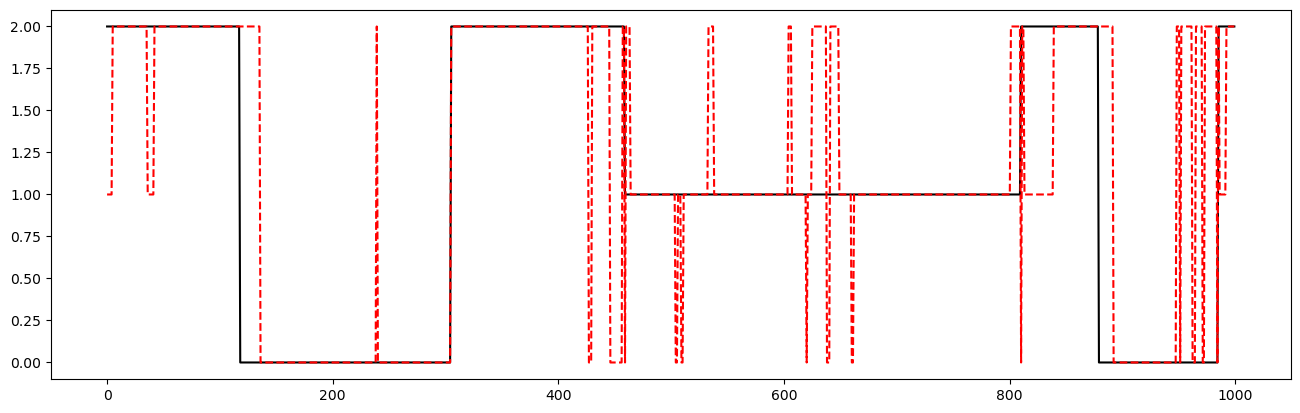

In [38]:
# val subset

val_true_subset = np.concatenate(val.feature_labels)[:1000]
val_pred_subset = val_pred_fhmm[:1000]
val_features_subset = np.concatenate(val.features)[:1000]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
# useful.vis_helper(val_features_subset)

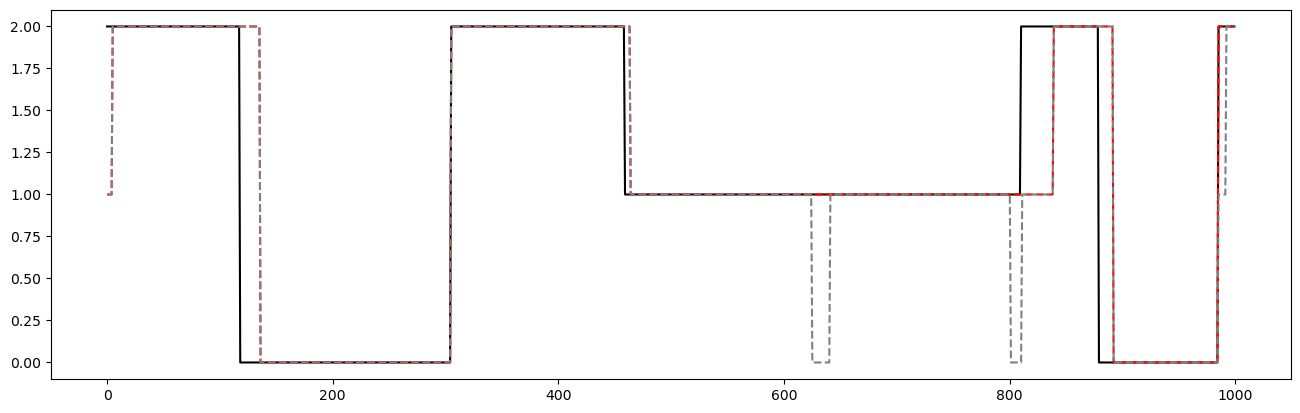

In [39]:
importlib.reload(useful)

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset, c='black')
plt.plot(useful.smooth_labels(val_pred_subset_smoothed), '--', c='red')
plt.plot(val_pred_subset_smoothed, '--', c='grey')

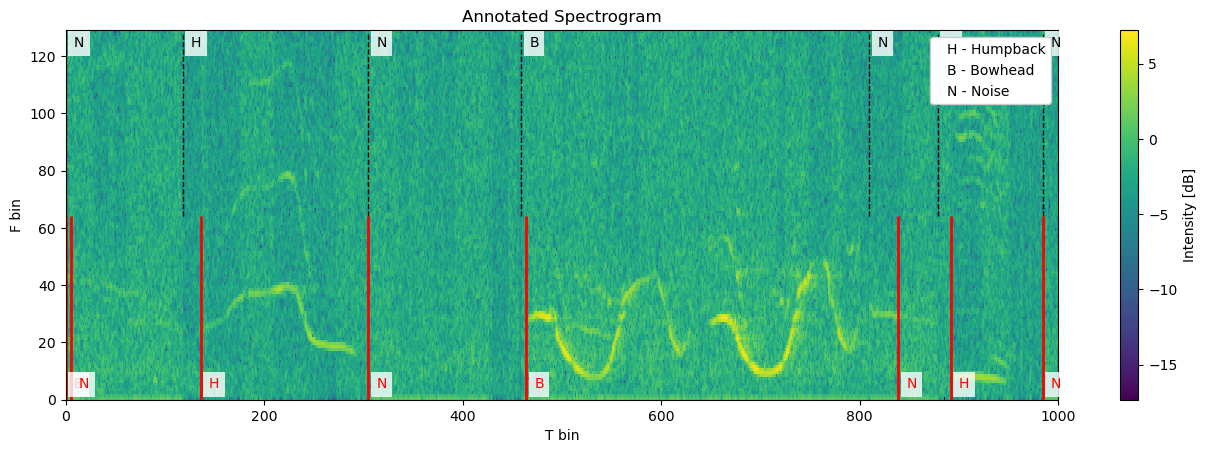

In [46]:
label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, useful.smooth_labels(val_pred_subset_smoothed), label_to_type, label_to_abr)

# Testing

In [103]:
importlib.reload(useful)
test.features = []
for i in range(len(test.samples)):
    feature = get_feature(test.samples[i])
    test.features.append(feature)
test.update_feature_labels()

In [55]:
test_features_concat = np.concatenate(test.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)

decoding using hmmlearn


In [56]:
test_features_concat_subset = test_features_concat[:1000,:]
test_pred_subset = test_pred[:1000]

In [76]:

smoothed_labels = useful.smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

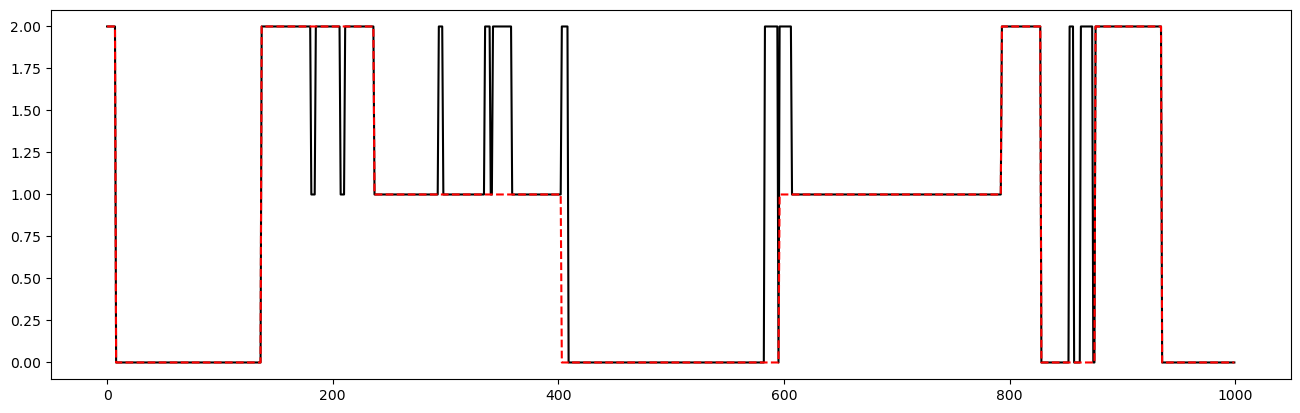

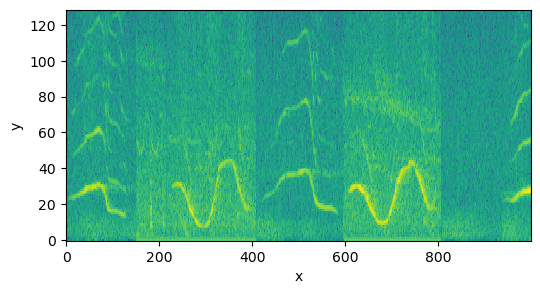

In [77]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, '--', c='red')
useful.vis_helper(test_features_concat_subset)

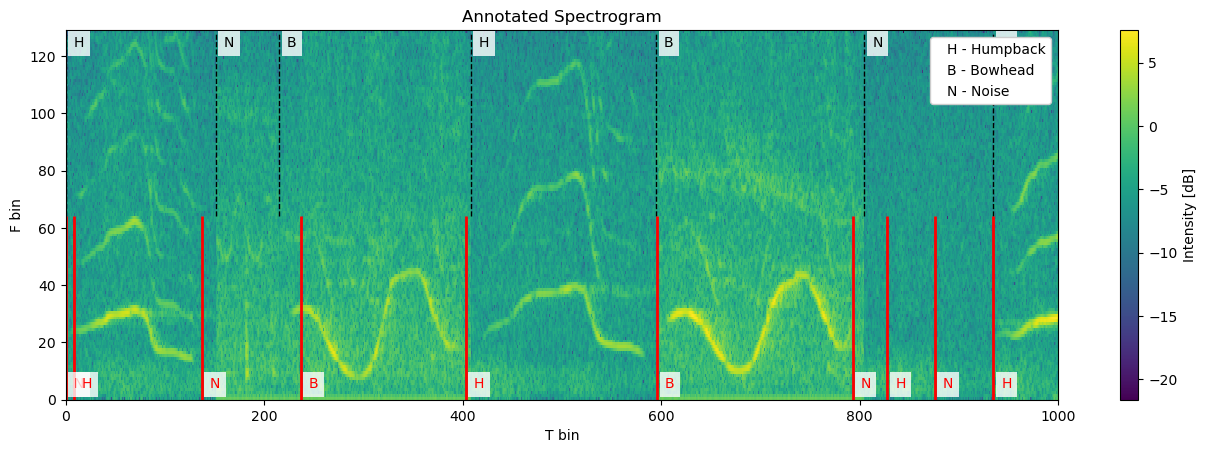

In [135]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat_subset, np.concatenate(test.feature_labels)[:1000], smoothed_labels, label_to_type, label_to_abr)